In [1]:
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import re
import glob
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
# Function to sort filenames alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Load and preprocess MRI dataset
def load_mri_data(dataset_path, img_size=(128, 128), batch_size=64):
    images = []
    
    subsets = {
        "train": os.path.join(dataset_path, "non_augmented", "image"),
        "test": os.path.join(dataset_path, "testing", "image")
    }
    
    for subset, path in subsets.items():
        if not os.path.exists(path):
            continue

        # Process both ed and es images
        for phase in ["ed_training", "es_training"] if subset == "train" else ["ed_testing", "es_testing"]:
            phase_path = os.path.join(path, phase)
            image_paths = sorted_alphanumeric(glob.glob(os.path.join(phase_path, "*")))

            for img_file in tqdm(image_paths, total=len(image_paths), desc=f"Processing {subset}/{phase}"):
                image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

                if image is None:
                    image = np.zeros(img_size, dtype=np.uint8)

                image = cv2.resize(image, img_size)

                # Normalize images to [-1, 1]
                image = (image.astype(np.float32) - 127.5) / 127.5

                images.append(img_to_array(image))

    images = np.array(images)

    # Convert to TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1024).batch(batch_size)

    return dataset

# Load and process dataset
DATASET_PATH = "/kaggle/input/cardiac-mri-dataset/CardiacMRIDataset"
dataset = load_mri_data(DATASET_PATH)

# Print dataset size
num_batches = sum(1 for _ in dataset)
print(f"Dataset loaded with {num_batches} batches")

Processing test/es_testing: 100%|██████████| 244/244 [00:02<00:00, 84.45it/s]


Dataset loaded with 29 batches


In [3]:
num_images = sum(1 for _ in dataset.unbatch())
print(f"Total number of images: {num_images}")

Total number of images: 1828


In [4]:
import matplotlib.pyplot as plt

def plot_real_images(images, n=4):
    total_images = images.shape[0]
    display_n = min(n * n, total_images)

    plt.figure(figsize=(n * 4, n * 4))
    
    for i in range(display_n):
        plt.subplot(n, n, i + 1)
        plt.imshow(images[i].squeeze() * 0.5 + 0.5, cmap="gray")  # Normalize back to [0,1]
        plt.axis("off")
        plt.title(f"Image {i+1}")

    plt.suptitle("Real Images", fontsize=16)
    plt.tight_layout()
    plt.show()

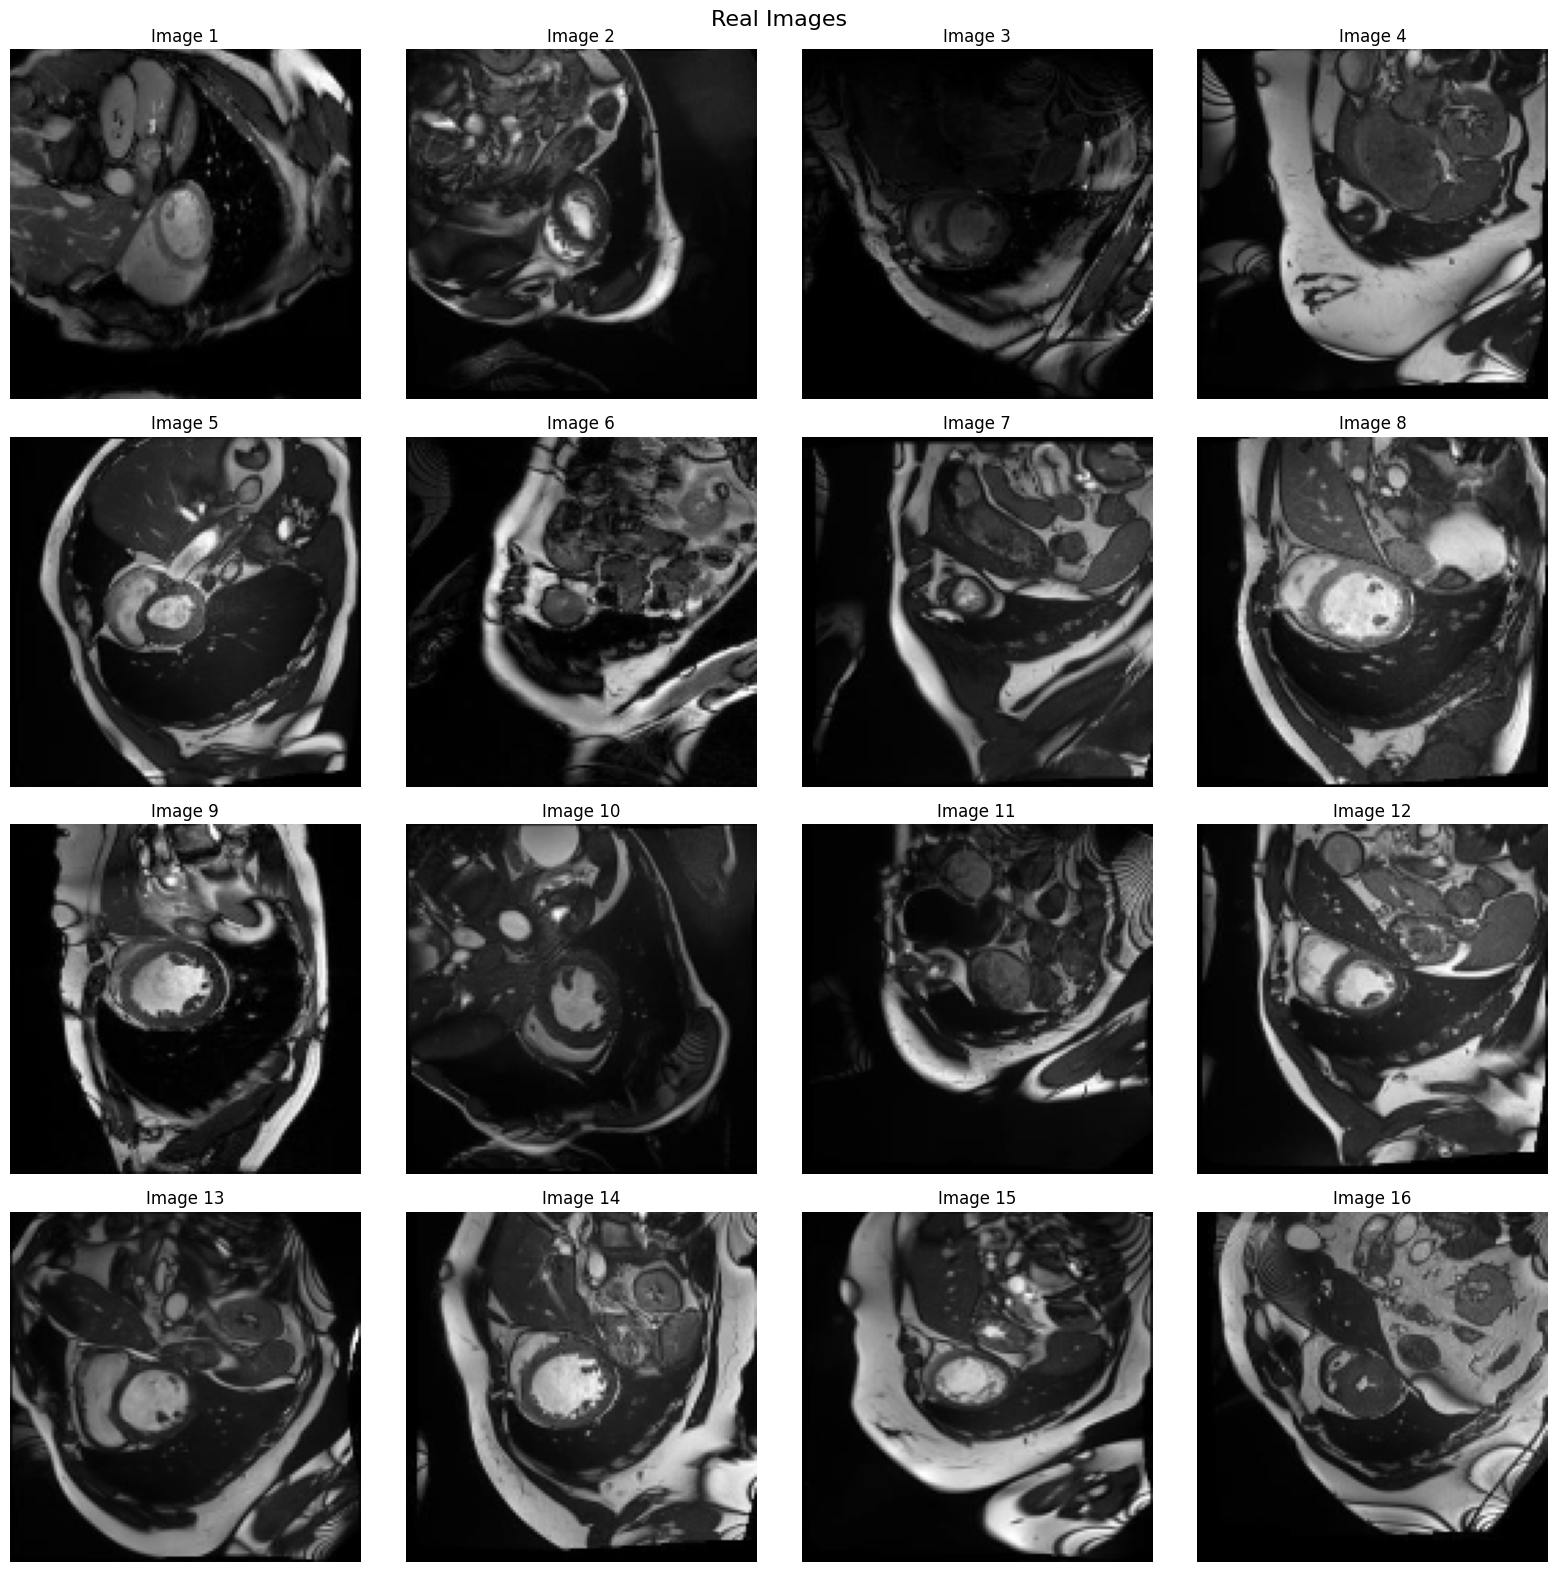

In [5]:
# Get a batch from the dataset
for batch in dataset.take(1):  
    images = batch.numpy()  # Only images are included now
    break  

# Plot real images
plot_real_images(images, n=4)

In [6]:
import tensorflow as tf

# Gradient penalty function
def gradient_penalty(discriminator, real_images, fake_images):
    """Computes the gradient penalty for WGAN-GP."""
    batch_size = tf.shape(real_images)[0]

    # Ensure images have 4D shape (batch, height, width, channels)
    if len(real_images.shape) == 3:  # If grayscale images are missing a channel
        real_images = tf.expand_dims(real_images, axis=-1)
        fake_images = tf.expand_dims(fake_images, axis=-1)

    # Ensure alpha has correct shape
    alpha = tf.random.uniform([batch_size, 1, 1, 1], minval=0.0, maxval=1.0)

    # Interpolate between real and fake images
    interpolated = real_images * alpha + fake_images * (1 - alpha)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)  # Ensure discriminator is in training mode

    # Compute gradients
    grads = gp_tape.gradient(pred, interpolated)

    # Compute gradient norm
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-8)  # Avoid NaNs

    # Compute gradient penalty
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

LATENT_DIM = 100  # Define latent space dimension

# Define Generator
def build_generator(LATEDNT_DIM):
    model = keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=LATENT_DIM),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(256, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh"),
    ])
    return model

# Create generator instance
generator = build_generator(LATENT_DIM)
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 3)         │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,364,035 (12.83 MB)

 Trainable params: 3,363,139 (12.83 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
SIZE = 128

# Discriminator
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding="same", input_shape=(128, 128, 3)),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, 4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1),
    ])
    return model


# Create discriminator instance
discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 724,417 (2.76 MB)

 Trainable params: 724,417 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Hyperparameters

BATCH_SIZE = 64
LATENT_DIM = 100
EPOCHS = 80
GP_WEIGHT = 50
N_CRITIC = 5

# Initialize Generator & Discriminator
generator = build_generator(LATENT_DIM)  # Pass LATENT_DIM explicitly
discriminator = build_discriminator()

# Adam Optimizers (Learning Rate and Beta values tuned for stability)
gen_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
disc_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

# Lists to store losses
gen_losses = []
disc_losses = []

In [10]:
import tensorflow as tf
import numpy as np

# Updated train_step function (Without Masks)
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Generate random noise for generator input
    noise = tf.random.normal([batch_size, LATENT_DIM])

    # Train Discriminator multiple times per Generator step (WGAN-GP stability)
    for _ in range(N_CRITIC):
        with tf.GradientTape() as disc_tape:
            fake_images = generator(noise, training=True)

            # Get discriminator outputs (now only using images)
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(fake_images, training=True)

            # Compute gradient penalty
            gp = gradient_penalty(discriminator, real_images, fake_images)

            # Compute discriminator loss
            disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + GP_WEIGHT * gp

        # Apply gradients for discriminator
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Train Generator once after `N_CRITIC` discriminator steps
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)

        # Get discriminator prediction for generated images
        fake_output = discriminator(fake_images, training=True)

        # Compute generator loss (Wasserstein loss)
        gen_loss = -tf.reduce_mean(fake_output)

    # Apply gradients for generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return disc_loss, gen_loss

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    disc_epoch_loss = []
    gen_epoch_loss = []

    for real_images in dataset:
        real_images = tf.reshape(real_images, (-1, 128, 128, 1))  # Ensure single-channel shape
        real_images = tf.image.grayscale_to_rgb(real_images)  # Convert to 3 channels
        
        d_loss, g_loss = train_step(real_images)


        # Store loss values
        disc_epoch_loss.append(d_loss.numpy())
        gen_epoch_loss.append(g_loss.numpy())

    # Track average loss per epoch
    disc_losses.append(np.mean(disc_epoch_loss))
    gen_losses.append(np.mean(gen_epoch_loss))

    print(f"D Loss: {disc_losses[-1]:.4f}, G Loss: {gen_losses[-1]:.4f}")

Epoch 1/80
D Loss: -212.7182, G Loss: 26.0838
Epoch 2/80
D Loss: -152.4194, G Loss: -22.3181
Epoch 3/80
D Loss: -119.1293, G Loss: 12.9201
Epoch 4/80
D Loss: -79.2533, G Loss: -15.8881
Epoch 5/80
D Loss: -38.5534, G Loss: -41.1808
Epoch 6/80
D Loss: -28.0287, G Loss: -15.5054
Epoch 7/80
D Loss: -24.2444, G Loss: 9.1490
Epoch 8/80
D Loss: -19.7939, G Loss: -2.8578
Epoch 9/80
D Loss: -18.6024, G Loss: -13.3339
Epoch 10/80
D Loss: -17.7715, G Loss: -10.0546
Epoch 11/80
D Loss: -17.1517, G Loss: -13.4266
Epoch 12/80
D Loss: -16.6892, G Loss: -29.9313
Epoch 13/80
D Loss: -16.3792, G Loss: -38.4970
Epoch 14/80
D Loss: -16.9579, G Loss: -40.5522
Epoch 15/80
D Loss: -15.9673, G Loss: -53.2177
Epoch 16/80
D Loss: -15.5125, G Loss: -43.7094
Epoch 17/80
D Loss: -15.5421, G Loss: -29.3540
Epoch 18/80
D Loss: -16.3097, G Loss: -13.4646
Epoch 19/80
D Loss: -16.1870, G Loss: -25.4400
Epoch 20/80
D Loss: -16.0336, G Loss: -45.6433
Epoch 21/80
D Loss: -16.1189, G Loss: -43.7442
Epoch 22/80
D Loss: -16.

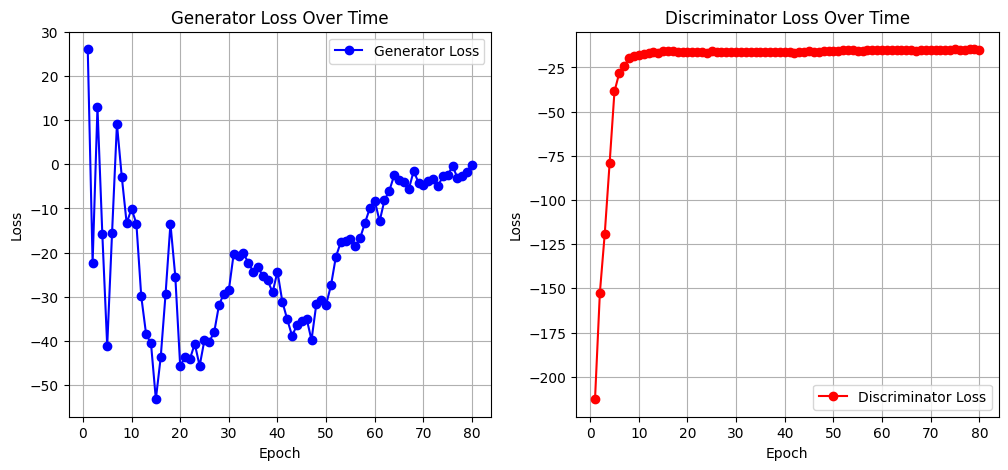

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(gen_losses, disc_losses):
    plt.figure(figsize=(12, 5))

    # Generator Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss", color='blue', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator Loss Over Time")
    plt.legend()
    plt.grid()

    # Discriminator Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss", color='red', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss Over Time")
    plt.legend()
    plt.grid()

    plt.show()

# Call the function after training
plot_loss_curves(gen_losses, disc_losses)

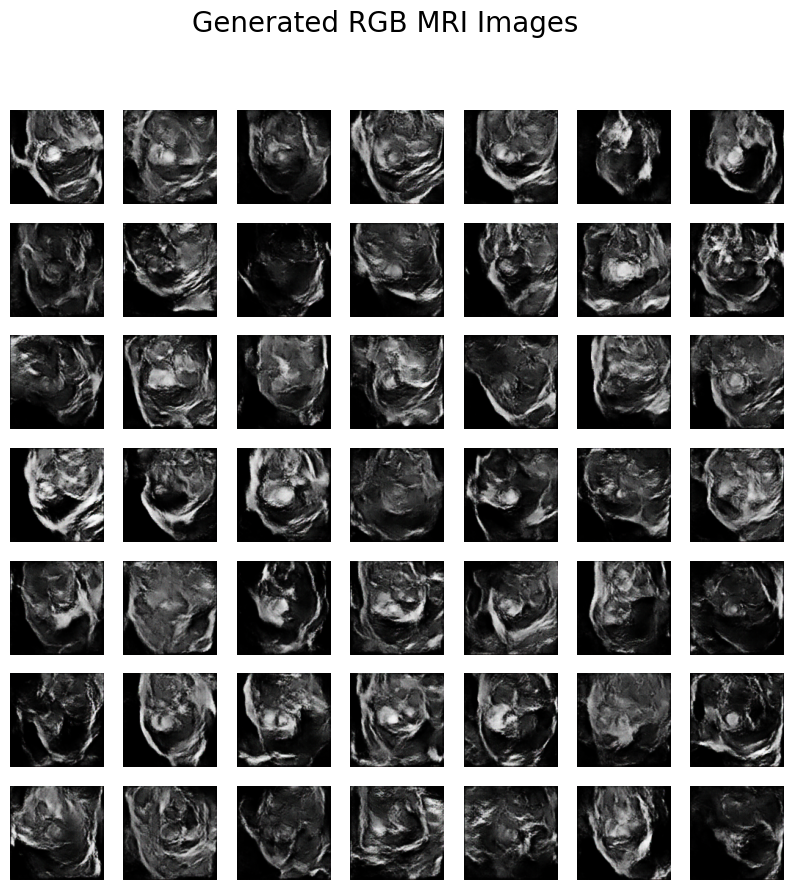

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf

# ============================
# Function to plot generated images (for RGB MRI)
# ============================
def plot_generated_images(n=5):
    noise = tf.random.normal([n * n, LATENT_DIM])
    generated_images = generator(noise, training=False)
    
    # Ensure images have the correct RGB shape (128, 128, 3)
    if generated_images.shape[-1] == 1:  # Convert grayscale to RGB if needed
        generated_images = tf.image.grayscale_to_rgb(generated_images)

    # Rescale from [-1, 1] to [0, 1] for proper visualization
    generated_images = (generated_images * 0.5) + 0.5  

    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i])  # No cmap needed for RGB
        plt.axis('off')

    plt.suptitle("Generated RGB MRI Images", fontsize=20)
    plt.show()

# Example usage: Generate and plot a 7x7 grid of images
plot_generated_images(7)

In [13]:
import os
import glob
import shutil
import re
import cv2
import numpy as np
from tqdm import tqdm

# Function to sort filenames alphanumerically
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Define dataset paths
DATASET_PATH = "/kaggle/input/cardiac-mri-dataset/CardiacMRIDataset"
REAL_IMAGE_PATHS = [
    os.path.join(DATASET_PATH, "non_augmented", "image", "ed_training"),
    os.path.join(DATASET_PATH, "non_augmented", "image", "es_training"),
    os.path.join(DATASET_PATH, "testing", "image", "ed_testing"),
    os.path.join(DATASET_PATH, "testing", "image", "es_testing")
]

# Path to generated images (fake)
FAKE_IMAGE_PATH = "/kaggle/working/generated_images"  # Update this if needed

# Create output folders
OUTPUT_FOLDER = "/kaggle/working/realfake"
REAL_FOLDER = os.path.join(OUTPUT_FOLDER, "real")
FAKE_FOLDER = os.path.join(OUTPUT_FOLDER, "fake")

os.makedirs(REAL_FOLDER, exist_ok=True)
os.makedirs(FAKE_FOLDER, exist_ok=True)

# Copy real images
for real_path in REAL_IMAGE_PATHS:
    if os.path.exists(real_path):
        image_files = sorted_alphanumeric(glob.glob(os.path.join(real_path, "*")))
        for img_file in tqdm(image_files, desc=f"Copying from {real_path}"):
            shutil.copy(img_file, REAL_FOLDER)

# Copy generated (fake) images
fake_images = sorted_alphanumeric(glob.glob(os.path.join(FAKE_IMAGE_PATH, "*")))
for img_file in tqdm(fake_images[:1828], desc="Copying generated images (fake)"):
    shutil.copy(img_file, FAKE_FOLDER)

print("✅ All real and fake images are organized in 'realfake' folder.")


Copying from /kaggle/input/cardiac-mri-dataset/CardiacMRIDataset/non_augmented/image/ed_training: 100%|██████████| 676/676 [00:02<00:00, 277.99it/s]
Copying from /kaggle/input/cardiac-mri-dataset/CardiacMRIDataset/non_augmented/image/es_training: 100%|██████████| 646/646 [00:02<00:00, 288.48it/s]
Copying from /kaggle/input/cardiac-mri-dataset/CardiacMRIDataset/testing/image/ed_testing: 100%|██████████| 262/262 [00:00<00:00, 264.18it/s]
Copying from /kaggle/input/cardiac-mri-dataset/CardiacMRIDataset/testing/image/es_testing: 100%|██████████| 244/244 [00:00<00:00, 311.79it/s]
Copying generated images (fake): 0it [00:00, ?it/s]

✅ All real and fake images are organized in 'realfake' folder.
